# CIVE70011 Operational Research and Systems Analysis
### Majd Yousof
### CID: 02061161

To start running this file, it would be recommended to do so in a python `venv` environment, or any other environment management package of your choice. A `requirements.txt` file has been provided that contains the necessary dependencies, that can be installed into the activated environment using the following shell script:

```bash
pip install -r requirements.txt
```
Thank You!

In [141]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Part 1: Exploratory Data analysis
In this section, the data and possible insights are extracted.

In [142]:
# loading the dataset
data = pd.read_csv('cw_dataset.csv')
data

,id,house_type,locality,city,area,beds,bathrooms,balconies,furnishing,area_rate,rent
0,1,"2 BHK Flat for Rent in Oberoi Woods, Goregaon ...",Goregaon East,Mumbai,897,2,2,0,Semi-Furnished,134.0,120000.0
1,2,"1 BHK Flat for Rent in Sapphire Lakeside, Powa...",Powai,Mumbai,490,1,1,0,Semi-Furnished,82.0,40000.0
2,3,1 BHK House for Rent in Mundhwa Pune,Mundhwa,Pune,550,1,1,0,Unfurnished,22.0,12000.0
3,4,"2 BHK Flat for Rent in Hingna, Nagpur",Hingna,Nagpur,1000,2,2,0,Unfurnished,8.0,8000.0
4,5,1 BHK Flat for Rent in Unique Star Harsh Vihar...,Mira Road,Mumbai,595,1,1,0,Unfurnished,25.0,15000.0
...,...,...,...,...,...,...,...,...,...,...,...
7686,7687,"3 BHK Flat for Rent in Saket, New Delhi",Saket,New Delhi,1750,3,3,0,Furnished,27.0,47000.0
7687,7688,"2 BHK Flat for Rent in Phase 7 JP Nagar, Banga...",Phase 7 JP Nagar,Bangalore,1050,2,2,2,Semi-Furnished,27.0,28000.0
7688,7689,"2 BHK Flat for Rent in Malpani Vivanta, Balewa...",Balewadi,Pune,734,2,2,2,Unfurnished,48.0,35000.0
7689,7690,"1 BHK Flat for Rent in Shalimar bagh, New Delhi",Shalimar bagh,New Delhi,400,1,1,0,Semi-Furnished,38.0,15000.0


## Question 1: 
Calculate the mean, standard deviation, and percentiles for each of the numerical features in the dataset, then Calculate the number of apartments at each city and plot the average rent price in each city.

In [143]:
# calculating the means, standard deviations, and percentiles of the area, beds, bathrooms, balconies, area_rate, and rent columns
descriptions = data[['area', 'beds', 'bathrooms', 'balconies', 'area_rate', 'rent']].describe()
descriptions

,area,beds,bathrooms,balconies,area_rate,rent
count,7691.000000,7691.000000,7691.000000,7691.000000,7691.000000,7.691000e+03
mean,1106.354180,2.208685,2.137043,0.817319,47.619989,5.479508e+04
std,1197.426843,0.993481,1.027677,1.243361,68.989657,9.742006e+04
min,2.000000,1.000000,0.000000,0.000000,2.000000,1.000000e+03
25%,600.000000,1.000000,1.000000,0.000000,21.000000,1.500000e+04
50%,900.000000,2.000000,2.000000,0.000000,31.000000,2.800000e+04
75%,1300.000000,3.000000,3.000000,2.000000,54.000000,5.700000e+04
max,70000.000000,10.000000,10.000000,10.000000,2586.000000,2.700000e+06


### A few things that can be noticed from the `descriptions` dataframe:
 
The mean `rent`,`balconies`,`area_rate` and `area` are significantly higher than their respective medians; can either indicate that the rent distribution is positively skewed, or that the data contains a few outliers that affect the calculation of the mean.

In [144]:
# calculating the number of apartments in each city
cityApartmentCount = data['city'].value_counts()

# calculating the mean rent for each city
cityMeanRent = data.groupby('city')['rent'].mean()

citystats = pd.DataFrame({'count': cityApartmentCount, 'meanRent': cityMeanRent})
citystats

,count,meanRent
city,,
Bangalore,1790,56709.260894
Mumbai,1719,103226.538104
Nagpur,595,18015.784874
New Delhi,1808,41309.158739
Pune,1779,32077.928612


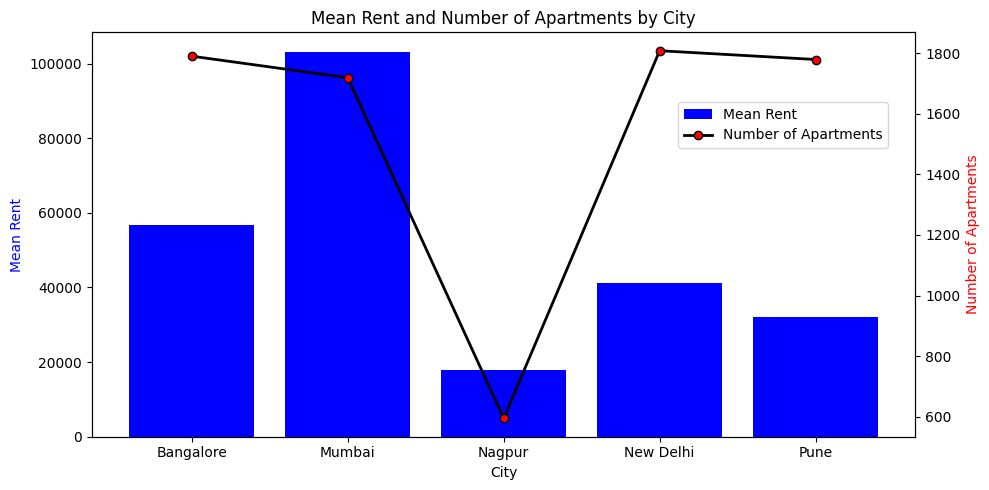

In [145]:
## plotting the mean rent by city, with the number of apartments in each city as a secondary y-axis
fig, ax = plt.subplots(figsize=(10, 5))

# Mean rent by city
ax.bar(citystats.index, citystats['meanRent'], color='blue', label='Mean Rent')
ax.set_ylabel('Mean Rent', color='blue')
ax.set_xlabel('City')
ax.set_title('Mean Rent and Number of Apartments by City')

# Number of apartments by city
ax2 = ax.twinx()
ax2.plot(citystats.index, citystats['count'], color='black', marker='o', mec='black', mfc='red', linewidth=2, label='Number of Apartments')
ax2.set_ylabel('Number of Apartments', color='red')

# Adding the legend
fig.legend(['Mean Rent','Number of Apartments'], loc='upper right', bbox_to_anchor=(0.9, 0.8))

# plotting
plt.tight_layout()
plt.savefig('plots/rawMeanRent.svg')
plt.show()


## Question 2:
Removal of outliers and analysing data again.

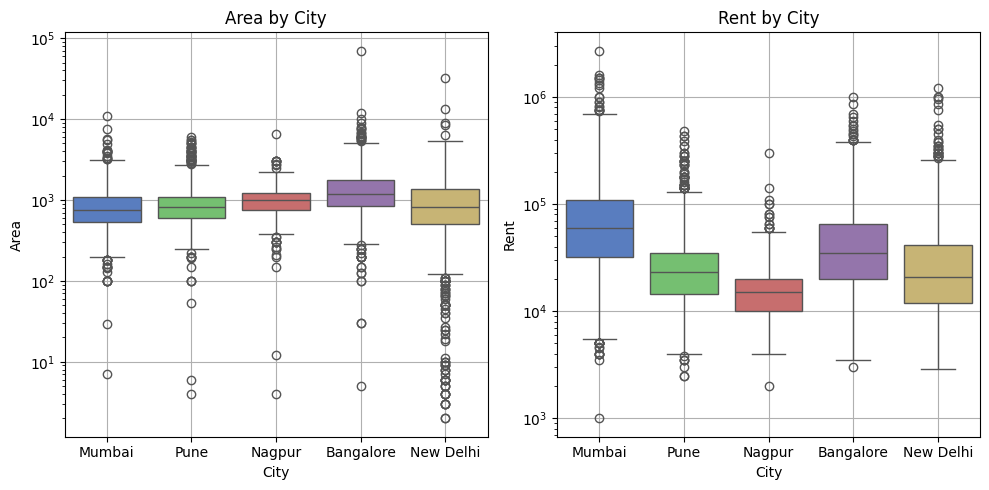

In [146]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plotting the boxplot of the area by city
sns.boxplot(data=data, x= 'city', y= 'area', ax=axs[0],log_scale=True, palette='muted6', hue='city')
axs[0].set_title('Area by City')
axs[0].set_ylabel('Area')
axs[0].set_xlabel('City')
axs[0].grid(True)

# plotting the boxplot of the rent by city
sns.boxplot(data=data, x= 'city', y= 'rent', ax=axs[1],log_scale=True, palette='muted6', hue='city')
axs[1].set_title('Rent by City')
axs[1].set_ylabel('Rent')
axs[1].set_xlabel('City')
axs[1].grid(True)

plt.tight_layout()
plt.savefig('plots/compBoxPlot.svg')
plt.show()

These boxplots indicate that there are indeed many outliers within the dataset, however, removing all the outliers that lie beyond the quantiles of the dataset may not be the best option, as there is a significant amount which may affect the representative accuracy of the dataset. It would be wise to compare area and rent prices per city (as done below), to capture more information about the outliers.

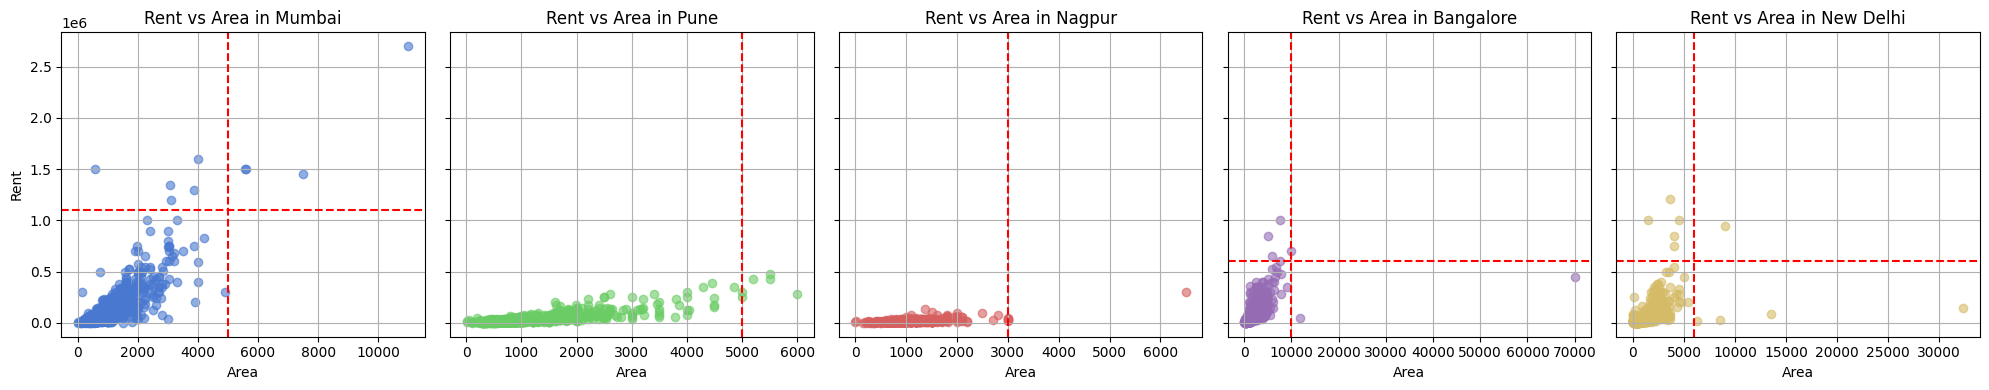

In [147]:
# Get unique cities
cities = data['city'].unique()

# initialising the thresholds for rent and area (explanation in the next cell)
rentthresholds = {'Mumbai': 1100000, 'Bangalore': 600000, 'New Delhi': 600000, 'Pune': 1e30, 'Nagpur': 1e30} # 1e30 is a very large number
areathresholds = {'Mumbai': 5000, 'Bangalore': 10000, 'New Delhi': 6000, 'Pune': 5000, 'Nagpur': 3000}

# Create a figure and subplots with a grid of 1 row and len(cities) columns
fig, axs = plt.subplots(1, len(cities), figsize=(20, 4), sharey=True)

# Loop through each city and create a scatter plot for each
for i, city in enumerate(cities):
    city_data = data[data['city'] == city]  # Filter data by city
    axs[i].scatter(city_data['area'], city_data['rent'], color= sns.color_palette('muted6')[i], alpha=0.6, marker='o')

    if city_data.max()['rent'] > rentthresholds[city]:
        axs[i].axhline(rentthresholds[city], color='red', linestyle='--', label='Rent Threshold')
    if city_data.max()['area'] > areathresholds[city]:
        axs[i].axvline(areathresholds[city], color='red', linestyle='--', label='Area Threshold')

    axs[i].set_title(f'Rent vs Area in {city}')
    axs[i].grid(True)
    axs[i].set_xlabel('Area')
    if i == 0:
        axs[i].set_ylabel('Rent')
    
# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('plots/compRentVsArea.svg')
plt.show()

For the Rent vs Area, it is clear that there are a few trends that are visible. It is also true that the visual outliers appear to be far fewer than before, so this plot will be mainly used to determine outliers. For this dataset, the outliers for each city lie **beyond**:

- ***Mumbai:*** Area = 5,000 or Rent = 1,100,000
- ***Pune:*** Area = 5,000
- ***Nagpur:*** Area = 3,000
- ***Bangalore:*** Area = 10,000 or Rent = 600,000
- ***New Delhi:*** Area = 6000 or Rent = 600,000

It is important to note that these values were ***not numerically calculated.*** From this, we can clean the dataset:

In [148]:
# filtering the data based on the thresholds
data_filtered = data.copy()
data_filtered = data_filtered[data_filtered.apply(lambda x: x['rent'] <= rentthresholds[x['city']] and x['area'] <= areathresholds[x['city']], axis=1)].reset_index(drop=True)
data_filtered

,id,house_type,locality,city,area,beds,bathrooms,balconies,furnishing,area_rate,rent
0,1,"2 BHK Flat for Rent in Oberoi Woods, Goregaon ...",Goregaon East,Mumbai,897,2,2,0,Semi-Furnished,134.0,120000.0
1,2,"1 BHK Flat for Rent in Sapphire Lakeside, Powa...",Powai,Mumbai,490,1,1,0,Semi-Furnished,82.0,40000.0
2,3,1 BHK House for Rent in Mundhwa Pune,Mundhwa,Pune,550,1,1,0,Unfurnished,22.0,12000.0
3,4,"2 BHK Flat for Rent in Hingna, Nagpur",Hingna,Nagpur,1000,2,2,0,Unfurnished,8.0,8000.0
4,5,1 BHK Flat for Rent in Unique Star Harsh Vihar...,Mira Road,Mumbai,595,1,1,0,Unfurnished,25.0,15000.0
...,...,...,...,...,...,...,...,...,...,...,...
7656,7687,"3 BHK Flat for Rent in Saket, New Delhi",Saket,New Delhi,1750,3,3,0,Furnished,27.0,47000.0
7657,7688,"2 BHK Flat for Rent in Phase 7 JP Nagar, Banga...",Phase 7 JP Nagar,Bangalore,1050,2,2,2,Semi-Furnished,27.0,28000.0
7658,7689,"2 BHK Flat for Rent in Malpani Vivanta, Balewa...",Balewadi,Pune,734,2,2,2,Unfurnished,48.0,35000.0
7659,7690,"1 BHK Flat for Rent in Shalimar bagh, New Delhi",Shalimar bagh,New Delhi,400,1,1,0,Semi-Furnished,38.0,15000.0


Finally, the equivalent barchart can be plotted:

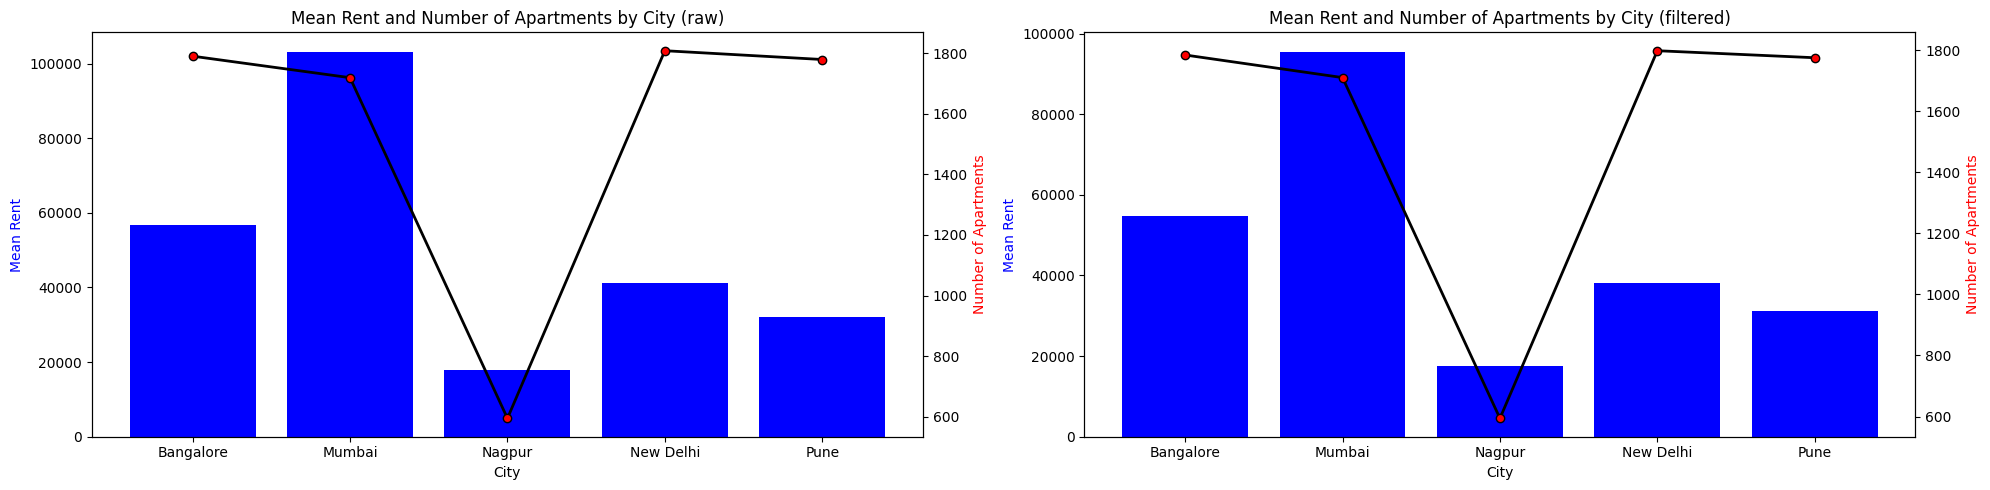

In [149]:
# calculating the number of apartments in each city
cityApartmentCount_filtered = data_filtered['city'].value_counts()

# calculating the mean rent for each city
cityMeanRent_filtered = data_filtered.groupby('city')['rent'].mean()

# creating a dataframe with the number of apartments and mean rent for each city
citystats_filtered = pd.DataFrame({'count': cityApartmentCount_filtered, 'meanRent': cityMeanRent_filtered})

dflist = [citystats, citystats_filtered]
stringlist = ['raw', 'filtered']

## plotting the mean rent by city, with the number of apartments in each city as a secondary y-axis
fig, ax = plt.subplots(1,2, figsize=(20, 5))

for i,df in enumerate(dflist):
    # Mean rent by city
    ax[i].bar(df.index, df['meanRent'], color='blue', label='Mean Rent')
    ax[i].set_ylabel('Mean Rent', color='blue')
    ax[i].set_xlabel('City')
    ax[i].set_title(f'Mean Rent and Number of Apartments by City ({stringlist[i]})')

    # Number of apartments by city
    ax2 = ax[i].twinx()
    ax2.plot(df.index, df['count'], color='black', marker='o', mec='black', mfc='red', linewidth=2, label='Number of Apartments')
    ax2.set_ylabel('Number of Apartments', color='red')

    # Adding the legend
    #fig.legend(['Mean Rent','Number of Apartments'], loc='upper right', bbox_to_anchor=(0.9, 0.8))

# plotting
plt.tight_layout()
plt.savefig('plots/compMeanRent.svg')
plt.show()

# Part 2: Regression

In this section, the focus now lies with the apartment size as the feature, where regressive models are established.

## Question 3:
Apply the least-square method to calculate the intercept and slope for the linear regression
equation that estimates apartment rent.